In [80]:
import re
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import datediff, col, lag, avg
from pyspark.sql.window import Window

In [2]:
sp = SparkSession.builder.appName("prelim analysis").config("spark.sql.session.timeZone", "+10").getOrCreate()
sp

22/09/26 12:19:29 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.17.231.204 instead (on interface eth0)
22/09/26 12:19:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 12:19:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Read all transactions together
from functools import reduce

dir = "../data/tables/"
groups = ["transactions_20210228_20210827_snapshot/", "transactions_20210828_20220227_snapshot/", "transactions_20220228_20220828_snapshot/"]
final_list = []

for g in groups:
    final_list.append(sp.read.parquet(dir + g))

trans = reduce(DataFrame.unionAll, final_list)
trans.show(4)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 4 rows



# Initial analysis on transactions

### Checking Dollar values by date

In [7]:
amount_per_day = trans.groupBy("order_datetime").sum("dollar_value").toPandas()
amount_per_day.head()

,order_datetime,sum(dollar_value)
0,2021-08-27,3.860810e+06
1,2021-07-30,3.714503e+06
2,2021-07-23,3.824223e+06
3,2021-08-21,4.235846e+06
4,2021-05-21,3.677561e+06


In [18]:
amount_per_day.columns = ["order dates", "transaction amount"]
amount_per_day["order dates"] = pd.to_datetime(amount_per_day["order dates"])
amount_per_day.sort_values(by="order dates", inplace=True)

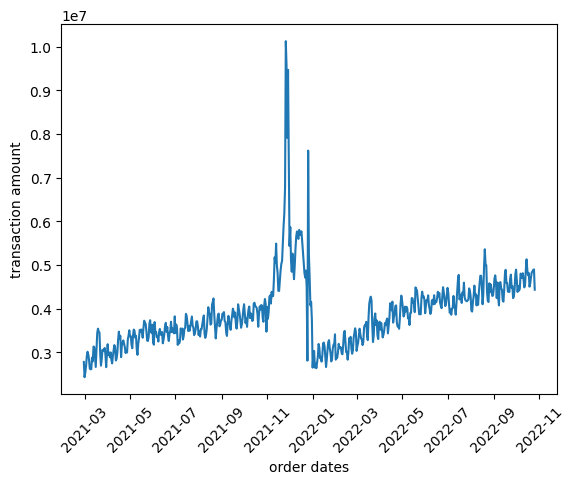

In [19]:
sns.lineplot(x="order dates", y="transaction amount", data=amount_per_day)
plt.xticks(rotation=45)
plt.show()

In [22]:
# Checking date limits
amount_per_day[amount_per_day["order dates"] > "2022-08-28"].count()

order dates           59
transaction amount    59
dtype: int64

We find that there are 59 transactions beyond the given date range. But that is fine as it simply adds to more relevant data.

Let's check the pattern seen in the above pattern more closely

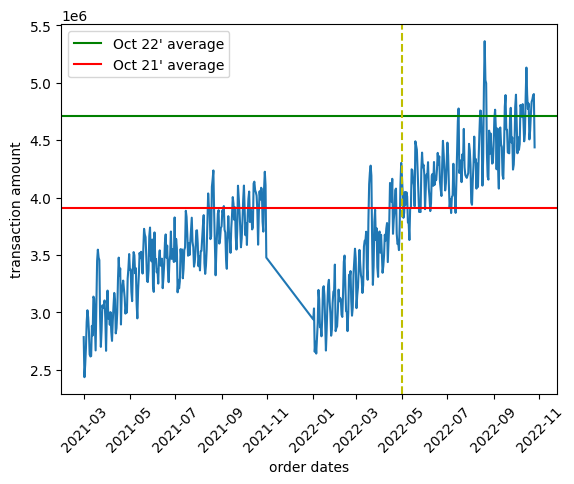

In [46]:
pattern_check = amount_per_day[(amount_per_day["order dates"] < "11-1-2021") | (amount_per_day["order dates"] >"1-1-2022")]

sns.lineplot(x="order dates", y="transaction amount", data=pattern_check)

oct_2011_avg = amount_per_day[(amount_per_day["order dates"] >= "10-1-2021") & (amount_per_day["order dates"] < "11-1-2021")]["transaction amount"].mean()
oct_2022_avg = amount_per_day[(amount_per_day["order dates"] >= "10-1-2022") & (amount_per_day["order dates"] < "11-1-2022")]["transaction amount"].mean()

plt.axhline(oct_2022_avg, color='g', label="Oct 22' average")
plt.axhline(oct_2011_avg, color='r', label="Oct 21' average")

plt.axvline(pd.to_datetime("5-1-2022"), color='y', linestyle="--")

plt.legend()

plt.xticks(rotation=45)
plt.show()

As seen in the graph, over the years of 21 and 22, there have been significant growth and fast paced recovery (considering a COVID effect on real-world like application). It is also important to note that there is a significant pattern in terms of purchasing power of customers. More of a deep dive is required to understand why it is an incresing trend every year rather than an overall increasing/linear trend

#### Special analysis of holiday season

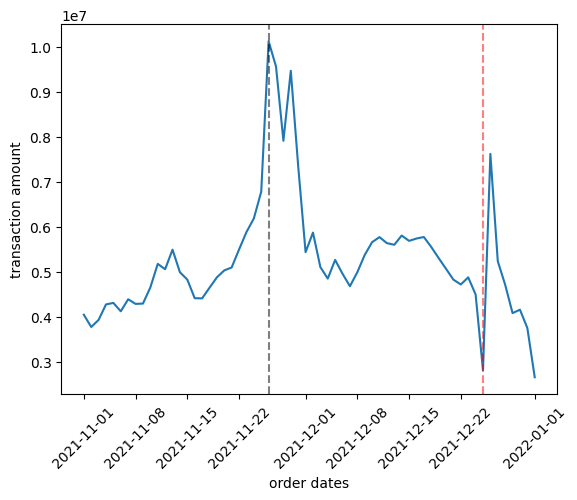

In [50]:
holiday_check = amount_per_day[(amount_per_day["order dates"] >= "11-1-2021") & (amount_per_day["order dates"] <= "1-1-2022")]

sns.lineplot(x="order dates", y="transaction amount", data=holiday_check)

plt.axvline(pd.to_datetime("12-25-2021"), color='r', linestyle="--", label="Christmas", alpha=0.5)
plt.axvline(pd.to_datetime("11-26-2021"), color='black', linestyle="--", label="Black Friday", alpha=0.5)

plt.xticks(rotation=45)
plt.show()

#### Analysis of average transaction values

In [53]:
avg_per_day = trans.groupBy("order_datetime").avg("dollar_value").toPandas()
avg_per_day.columns = ["Order dates", "Average value"]
avg_per_day["Order dates"] = pd.to_datetime(avg_per_day["Order dates"])
avg_per_day.sort_values(by="Order dates", inplace=True)
avg_per_day.head(5)

,Order dates,Average value
178,2021-02-28,162.745630
172,2021-03-01,160.523109
167,2021-03-02,164.955717
177,2021-03-03,167.070364
176,2021-03-04,171.635268


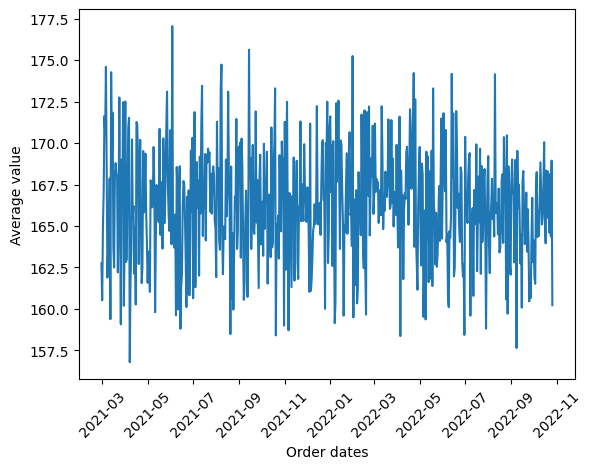

In [55]:
sns.lineplot(x="Order dates", y="Average value", data=avg_per_day)

plt.xticks(rotation=45)
plt.show()

As seen above, this is a fairly linear graph showing that the people still purchased items worth the same amount as they would during non-holiday periods

#### Group by day of week

In [116]:
day_of_week = amount_per_day.groupby(amount_per_day["order dates"].dt.day_name()).mean()
day_of_week.head(7)

,transaction amount
order dates,
Friday,4.032352e+06
Monday,3.892974e+06
Saturday,4.029424e+06
Sunday,3.972880e+06
Thursday,3.879779e+06
Tuesday,3.731880e+06
Wednesday,3.721004e+06


<AxesSubplot:xlabel='order dates'>

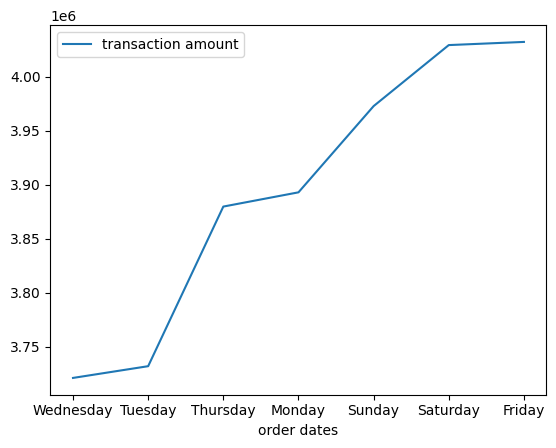

In [118]:
sns.lineplot(day_of_week.sort_values(by="transaction amount"))

Huge number of transactions seen over Fri-Sun. Monday and Thursday being almost equal but subpar to the weekend. Tuesday and Wednesday being the least of all

### Analysis with consumer data

In [66]:
consumer = sp.read.option("header", True).option("delimiter", "|").csv("../data/tables/tbl_consumer.csv")
consumer.show(2)

+----------------+--------------------+-----+--------+------+-----------+
|            name|             address|state|postcode|gender|consumer_id|
+----------------+--------------------+-----+--------+------+-----------+
|Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|    1195503|
|      Mary Smith|     3764 Amber Oval|  NSW|    2782|Female|     179208|
+----------------+--------------------+-----+--------+------+-----------+
only showing top 2 rows



In [69]:
consumer_details_pd = pd.read_parquet("../data/tables/consumer_user_details.parquet")
consumer_details_pd.head()

,user_id,consumer_id
0,1,1195503
1,2,179208
2,3,1194530
3,4,154128
4,5,712975


### Analysis with merchant data

In [88]:
merchant_pd = pd.read_parquet("../data/tables/tbl_merchants.parquet")
merchant_pd.head()

,name,tags
merchant_abn,,
10023283211,Felis Limited,"((furniture, home furnishings and equipment sh..."
10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a..."
10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]..."
10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]..."
10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a..."


In [89]:
merchant_pd.iloc[0]['tags']

'((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))'

In [90]:
merchant_pd.count()

name    4026
tags    4026
dtype: int64

In [91]:
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)

    # break the string into sections
    string_cut = string.split('),')
    new_string = []

    # first extract the description 
    new_string.append(str(string_cut[0].strip('((')))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))

    return(new_string)

################
tags = merchant_pd['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))


In [92]:
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'), index=merchant_pd.index)
merchant_tbl = pd.concat([merchant_pd, merchant_tbl], axis=1)

# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)
merchant_tbl.head()

,name,Description,Earnings_Class,BNPL_Fee
merchant_abn,,,,
10023283211,Felis Limited,"furniture, home furnishings and equipment shop...",e,0.18
10142254217,Arcu Ac Orci Corporation,"cable, satellite, and other pay television and...",b,4.22
10165489824,Nunc Sed Company,"jewelry, watch, clock, and silverware shops",b,4.40
10187291046,Ultricies Dignissim Lacus Foundation,"watch, clock, and jewelry repair shops",b,3.29
10192359162,Enim Condimentum PC,"music shops - musical instruments, pianos, and...",a,6.33


In [93]:
merchant_tbl.to_csv("../data/curated/merchants_tbl_processed.csv")

In [95]:
merchant_tbl = sp.read.option("header", True).csv("../data/curated/merchants_tbl_processed.csv")
merchant_tbl.show(3)

+------------+--------------------+--------------------+--------------+--------+
|merchant_abn|                name|         Description|Earnings_Class|BNPL_Fee|
+------------+--------------------+--------------------+--------------+--------+
| 10023283211|       Felis Limited|furniture, home f...|             e|    0.18|
| 10142254217|Arcu Ac Orci Corp...|cable, satellite,...|             b|    4.22|
| 10165489824|    Nunc Sed Company|jewelry, watch, c...|             b|     4.4|
+------------+--------------------+--------------------+--------------+--------+
only showing top 3 rows



In [96]:
merchants = trans.join(merchant_tbl, on="merchant_abn")
merchants.show(3)

+------------+-------+------------------+--------------------+--------------+--------------------+--------------------+--------------+--------+
|merchant_abn|user_id|      dollar_value|            order_id|order_datetime|                name|         Description|Earnings_Class|BNPL_Fee|
+------------+-------+------------------+--------------------+--------------+--------------------+--------------------+--------------+--------+
| 62191208634|  18478|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|Cursus Non Egesta...|furniture, home f...|             c|    2.17|
| 15549624934|      2| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|  Commodo Associates|opticians, optica...|             c|    2.76|
| 64403598239|  18479|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|Lobortis Ultrices...|music shops - mus...|             a|    6.31|
+------------+-------+------------------+--------------------+--------------+--------------------+--------------------+--------------+--

In [98]:
merchants = merchants.drop("name")
merchants.count()

13614675

In [99]:
merchants.show(2)

+------------+-------+------------------+--------------------+--------------+--------------------+--------------+--------+
|merchant_abn|user_id|      dollar_value|            order_id|order_datetime|         Description|Earnings_Class|BNPL_Fee|
+------------+-------+------------------+--------------------+--------------+--------------------+--------------+--------+
| 62191208634|  18478|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|furniture, home f...|             c|    2.17|
| 15549624934|      2| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|opticians, optica...|             c|    2.76|
+------------+-------+------------------+--------------------+--------------+--------------------+--------------+--------+
only showing top 2 rows



In [108]:
check_class = merchants.groupBy("merchant_abn").sum("dollar_value").join(merchant_tbl, on="merchant_abn")
check_class.show()

+------------+------------------+--------------------+--------------------+--------------+--------+
|merchant_abn| sum(dollar_value)|                name|         Description|Earnings_Class|BNPL_Fee|
+------------+------------------+--------------------+--------------------+--------------+--------+
| 38700038932| 9546185.360697314|Etiam Bibendum In...|tent and awning s...|             a|    6.31|
| 83412691377| 498536.5816973136|Suspendisse Sagit...|watch, clock, and...|             c|    2.94|
| 15613631617|  543030.531332826|     Ante Industries|motor vehicle sup...|             e|    0.35|
| 19839532017|          113982.0|Pellentesque Habi...|cable, satellite,...|             b|    4.94|
| 73256306726|1496967.1591142188|              Id LLP|health and beauty...|             b|    4.81|
| 35344855546|134737.25046268434|Quis Tristique Ac...|watch, clock, and...|             c|    2.92|
| 73841664453| 83314.29045077678|      Lacinia At LLP|digital  goods: b...|             a|    5.55|


In [109]:
check_class.groupBy("Earnings_Class").avg("sum(dollar_value)").show()

+--------------+----------------------+
|Earnings_Class|avg(sum(dollar_value))|
+--------------+----------------------+
|             e|     466409.1137064723|
|             d|     380160.4808673627|
|             c|     492228.4833728333|
|             b|     572100.8022827655|
|             a|     542033.4187956803|
+--------------+----------------------+



In [110]:
plot_class = check_class.toPandas()
plot_class.head()

,merchant_abn,sum(dollar_value),name,Description,Earnings_Class,BNPL_Fee
0,38700038932,9.546185e+06,Etiam Bibendum Industries,tent and awning shops,a,6.31
1,83412691377,4.985366e+05,Suspendisse Sagittis Nullam Associates,"watch, clock, and jewelry repair shops",c,2.94
2,15613631617,5.430305e+05,Ante Industries,motor vehicle supplies and new parts,e,0.35
3,19839532017,1.139820e+05,Pellentesque Habitant LLC,"cable, satellite, and other pay television and...",b,4.94
4,73256306726,1.496967e+06,Id LLP,health and beauty spas,b,4.81


In [124]:
#plot_class.info()
plot_class["BNPL_Fee"] = pd.to_numeric(plot_class["BNPL_Fee"])

In [125]:
plot_class["take away revenue"] = plot_class["BNPL_Fee"] * plot_class["sum(dollar_value)"] / 100
plot_class.head()

,merchant_abn,sum(dollar_value),name,Description,Earnings_Class,BNPL_Fee,take away revenue
0,38700038932,9.546185e+06,Etiam Bibendum Industries,tent and awning shops,a,6.31,602364.296260
1,83412691377,4.985366e+05,Suspendisse Sagittis Nullam Associates,"watch, clock, and jewelry repair shops",c,2.94,14656.975502
2,15613631617,5.430305e+05,Ante Industries,motor vehicle supplies and new parts,e,0.35,1900.606860
3,19839532017,1.139820e+05,Pellentesque Habitant LLC,"cable, satellite, and other pay television and...",b,4.94,5630.710800
4,73256306726,1.496967e+06,Id LLP,health and beauty spas,b,4.81,72004.120353


<AxesSubplot:xlabel='BNPL_Fee', ylabel='take away revenue'>

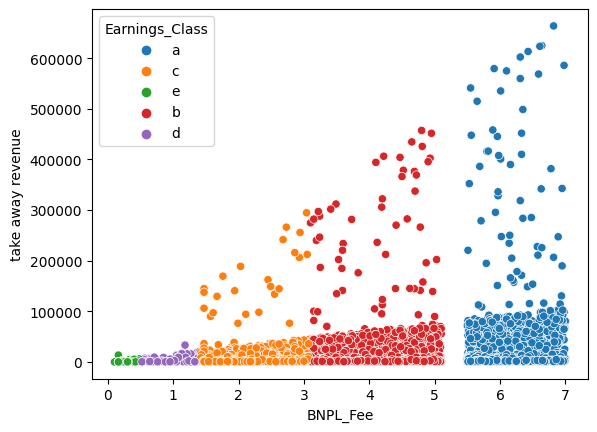

In [129]:
sns.scatterplot(x="BNPL_Fee", y="take away revenue", hue="Earnings_Class", data=plot_class)

<AxesSubplot:xlabel='sum(dollar_value)', ylabel='BNPL_Fee'>

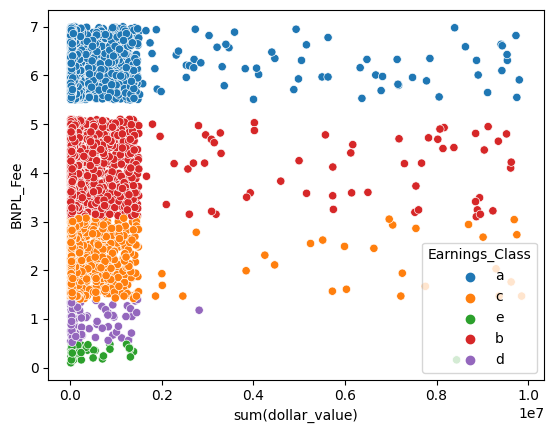

In [128]:
sns.scatterplot(x="sum(dollar_value)", y="BNPL_Fee", hue="Earnings_Class", data=plot_class)